# Restructure Hazard Function Calculations

In [1]:
from datetime import timedelta, date
from pathlib import Path

from lifelines import KaplanMeierFitter
import numpy as np
import pandas as pd
import plotnine as p9
import tqdm

from mizani.breaks import date_breaks
from mizani.formatters import timedelta_format

# Load the Data

In [2]:
published_dates = (
    pd.read_csv(
        "../publication_delay_experiment/output/biorxiv_published_dates.tsv", 
        sep="\t"
    )
    .assign(
        preprint_date = lambda x: pd.to_datetime(x.preprint_date.tolist()),
        published_date = lambda x: pd.to_datetime(
            x.published_date.apply(lambda y: y[0:y.index(":")] if ":" in y else y)
        )
    )
)
print(published_dates.shape)
published_dates.head()

(44397, 7)


,biorxiv_doi,published_doi,preprint_title,preprint_category,preprint_date,published_date,published_citation_count
0,10.1101/001081,10.1093/bioinformatics/btu121,PyRAD: assembly of de novo RADseq loci for phy...,Bioinformatics,2013-12-03,2014-03-05,184
1,10.1101/001297,10.1371/journal.pone.0085203,Aerodynamic characteristics of a feathered din...,Biophysics,2013-12-10,2014-01-15,11
2,10.1101/000422,10.3389/fgene.2014.00013,On the optimal trimming of high-throughput mRN...,Bioinformatics,2013-11-14,2014-01-31,44
3,10.1101/001396,10.1162/NECO_a_00568,Parametric inference in the large data limit u...,Biophysics,2013-12-13,2014-03-10,4
4,10.1101/002980,10.1016/j.bpj.2014.01.012,Genetic drift suppresses bacterial conjugation...,Biophysics,2014-02-24,2014-02-18,10


In [3]:
biorxiv_journal_df = (
    pd.read_csv(
        "../journal_tracker/output/mapped_published_doi.tsv", 
        sep="\t"
    )
    .groupby("preprint_doi")
    .agg({
        "document":"first",
        "category":"first",
        "preprint_doi":"count",
        "published_doi":"first",  
        "pmcid":"first", 
        "pmcoa":"first",
        "posted_date":"first"
    })
    .rename(index=str, columns={"preprint_doi":"version_count"})
    .reset_index()
)
print(biorxiv_journal_df.shape)
biorxiv_journal_df.head()

(71115, 8)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,posted_date
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,2013-11-07
1,10.1101/000042,000042_v1.xml,genomics,3,10.1038/nrg3723,PMC4151119,False,2013-11-07
2,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,2013-11-07
3,10.1101/000091,000091_v1.xml,synthetic biology,1,NaN,NaN,False,2013-11-07
4,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,2013-11-07


In [4]:
preprints_w_published_dates = (
    biorxiv_journal_df
    .sort_values("document")
    .merge(
        published_dates
        [["biorxiv_doi", "published_date"]]
        .rename(index=str, columns={"biorxiv_doi":"preprint_doi"}),
        on="preprint_doi",
        how="left"
    )
    .assign(
        published_date=lambda x: x.published_date.fillna(date.today())
    )
    .assign(
        time_to_published = lambda x: pd.to_datetime(x.published_date) - pd.to_datetime(x.posted_date)
    )
)
preprints_w_published_dates = (
    preprints_w_published_dates[
        preprints_w_published_dates.time_to_published > pd.Timedelta(0)
    ]
)
print(preprints_w_published_dates.shape)
preprints_w_published_dates.head()

(70910, 10)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,posted_date,published_date,time_to_published
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,2013-11-07,2014-08-07 00:00:00,273 days
1,10.1101/000042,000042_v1.xml,genomics,3,10.1038/nrg3723,PMC4151119,False,2013-11-07,2014-06-01 00:00:00,206 days
2,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,2013-11-07,2014-02-27 00:00:00,112 days
3,10.1101/000091,000091_v1.xml,synthetic biology,1,NaN,NaN,False,2013-11-07,2020-11-01,2551 days
4,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,2013-11-07,2014-06-26 00:00:00,231 days


# Calculate Overall Survival Function

In [5]:
kmf = KaplanMeierFitter()

In [6]:
kmf.fit(
    preprints_w_published_dates["time_to_published"].dt.total_seconds() / 60 / 60 / 24,
    event_observed= ~preprints_w_published_dates["published_doi"].isna(),
)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 70910 total observations, 30546 right-censored observations>

In [7]:
kmf.median_survival_time_

348.00000000000006

In [8]:
overall_preprint_survival = (
    kmf.survival_function_
    .reset_index()
    .assign(label="all_papers")
)
overall_preprint_survival.head()

,timeline,KM_estimate,label
0,0.0,1.000000,all_papers
1,1.0,0.999422,all_papers
2,2.0,0.998688,all_papers
3,3.0,0.998054,all_papers
4,4.0,0.997504,all_papers


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


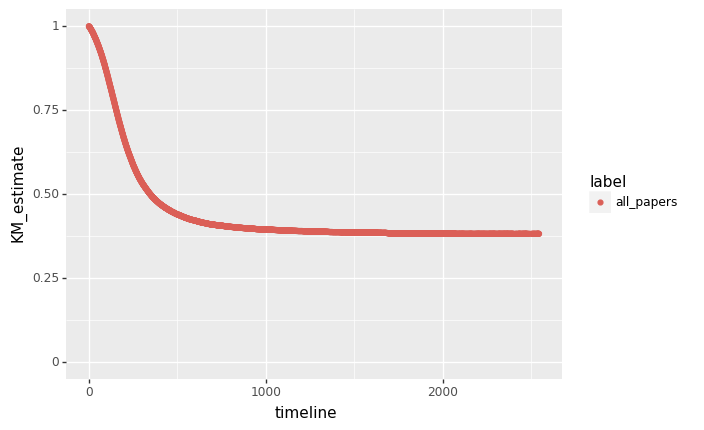

<ggplot: (-9223363259218744972)>


In [9]:
g = (
    p9.ggplot(overall_preprint_survival, p9.aes(x="timeline", y="KM_estimate", color="label"))
    + p9.geom_point()
    + p9.ylim(0,1)
    + p9.xlim(0, 2550)
)
print(g)

# Calculate Category Survival Function

In [10]:
entire_preprint_df = pd.DataFrame([], columns=["timeline", "KM_estimate", "category"])
half_life = []
for cat, grouped_df in preprints_w_published_dates.groupby("category"):
    temp_df = preprints_w_published_dates.query(f"category=='{cat}'")
    kmf.fit(
        temp_df["time_to_published"].dt.total_seconds() / 60 / 60 / 24,
        event_observed= ~temp_df["published_doi"].isna(),
    )
    
    half_life.append({
        "category":cat, 
        "half_life_time":kmf.median_survival_time_
    })
    
    entire_preprint_df = (
        entire_preprint_df
        .append(
            kmf.survival_function_
            .reset_index()
            .assign(category=cat)
        )
    )

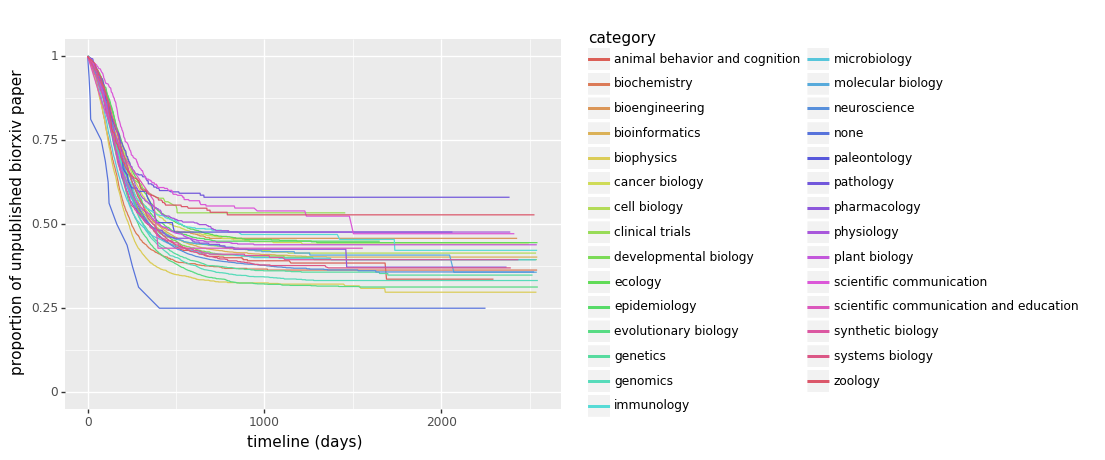

<ggplot: (8777635980934)>


In [11]:
g = (
    p9.ggplot(
        entire_preprint_df, 
        p9.aes(x="timeline", y="KM_estimate", color='category')
    )
    + p9.geom_line()
    + p9.ylim(0,1)
    + p9.xlim(0,2550)
    + p9.labs(
        x="timeline (days)",
        y="proportion of unpublished biorxiv paper"
    )
)
print(g)

In [12]:
category_half_life = (
    pd.DataFrame
    .from_records(half_life)
    .replace(np.inf, (temp_df["time_to_published"].dt.total_seconds() / 60 / 60 / 24).max())
)
category_half_life

,category,half_life_time
0,animal behavior and cognition,341.0
1,biochemistry,249.0
2,bioengineering,396.0
3,bioinformatics,393.0
4,biophysics,232.0
5,cancer biology,467.0
6,cell biology,376.0
7,clinical trials,2527.0
8,developmental biology,344.0
9,ecology,526.0


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/preprint_category_halflife.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/preprint_category_halflife.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


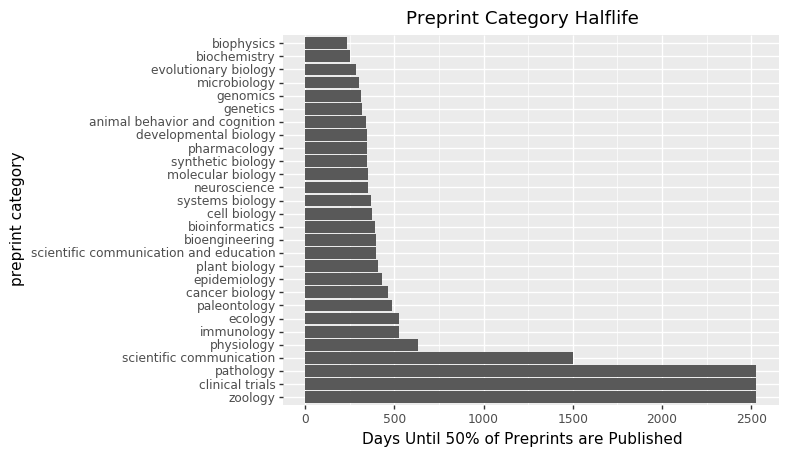

<ggplot: (8777633310163)>


In [13]:
g = (
    p9.ggplot(
        category_half_life.query("category!='none'"),
        p9.aes(x="category", y="half_life_time")
    )
    + p9.geom_col()
    + p9.scale_x_discrete(
        limits=(
            category_half_life
            .query("category!='none'")
            .sort_values("half_life_time", ascending=False)
            .category
            .tolist()
        )
    )
    + p9.coord_flip()
    + p9.labs(
        x="preprint category",
        y="Days Until 50% of Preprints are Published",
        title="Preprint Category Half-Life"
    )
)
g.save("output/preprint_category_halflife.svg", dpi=500)
g.save("output/preprint_category_halflife.png", dpi=500)
print(g)